 <table>
  <tr>
      <th>Índice (i)</th>
      <th>P</th>
      <th>Q</th>
      <th>R</th>
      <th>S</th>
      <th>T</th>
  </tr>
  <tr>
      <td>Tempo (s)</td>
      <td>-0.2</td>
      <td>-0.05</td>
      <td>0</td>
      <td>0.05</td>
      <td>0.3</td>
  </tr>
  <tr>
      <td>$$\theta_i \text{ (radianos)}$$</td>
      <td>$$-\frac{1}{3}\pi$$</td>
      <td>$$-\frac{1}{12}\pi$$</td>
      <td>0</td>
      <td>$$\frac{1}{12}\pi$$</td>
      <td>$$\frac{1}{2}\pi$$</td>
  </tr>
  <tr>
      <td>$$a_i$$</td>
      <td>1.2</td>
      <td>-5.0</td>
      <td>30.0</td>
      <td>-7.5</td>
      <td>0.75</td>
  </tr>
  <tr>
      <td>$$b_i$$</td>
      <td>0.25</td>
      <td>0.1</td>
      <td>0.1</td>
      <td>0.1</td>
      <td>0.40</td>
  </tr>
</table> 

Equações do movimento:

$$\dot{x} = \alpha x - \omega y$$

$$\dot{y} = \alpha y + \omega x$$

$$\dot{z} = - \sum_{i \in \{P, Q, R, S, T\}}{a_i \theta_i \exp\left(-\frac{\Delta\theta_i^2}{2b_i^2}\right)} - (z - z_0)$$

Onde:

$$ \alpha = \sqrt{x^2 + y^2} $$
$$ \Delta\theta_i = (\theta - \theta_i) \mod 2\pi $$
$$ \theta = \text{atan2}(y, x) $$
$$ \omega := \text{velocidade angular da trajetória circular} $$
$$ z_0(t) = A \sin(2\pi f_2 t)$$

Além disso, $ A = 0.15\text{mV} $ e $ f_2 $ é a frequência respiratória.

In [1]:
using Plots;

In [2]:
function rungekutta4(f, y0, t)
    n = length(t)
    y = zeros((n, length(y0)))
    y[1,:] = y0
    for i in 1:n-1
        h = t[i+1] - t[i]
        k1 = f(y[i,:], t[i])
        k2 = f(y[i,:] + k1 * h/2, t[i] + h/2)
        k3 = f(y[i,:] + k2 * h/2, t[i] + h/2)
        k4 = f(y[i,:] + k3 * h, t[i] + h)
        y[i+1,:] = y[i,:] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    end
    return y
end;

In [3]:
index = ['P', 'Q', 'R', 'S', 'T']
time = Dict(index .=> [-0.2, -0.05, 0.0, 0.05, 0.3])
θ_i = Dict(index .=> [-π/3, -π/12, 0.0, π/12, π/2])
a_i = Dict(index .=> [1.2, -5.0, 30.0, -7.5, 0.75])
b_i = Dict(index .=> [0.25, 0.1, 0.1, 0.1, 0.4])

f_1 = 0.10
f_2 = 0.25
f_s = 1000

θ_init = 3π/2;

x0 = [cos(θ_init), sin(θ_init), 0.0]
t0 = 0.0
n = 1000
t = 0:1/n:3

HR = 75;
tc = 60 / HR;

α(x, y) = 1 - √(x^2 + y^2)
ω(t) = 2π/tc # (π/2 + π/3) / (0.3 + 0.2)
Δθ(x, y, i) = (atan(x, y) - θ_i[i]) % 2π
A = 0.15e-3
z_0(t) = A * sin(2π * f_2 * t)

mcsharry(x, t) = [
    α(x[1], x[2]) * x[1] - ω(t) * x[2],
    ω(t) * x[1] + α(x[1], x[2]) * x[2],
    sum([a_i[i] * Δθ(x[1], x[2], i) * exp(-Δθ(x[1], x[2], i)^2 / 2b_i[i]^2) for i in index]) #- x[3] - z_0(t),
];

x = rungekutta4(mcsharry, x0, t);

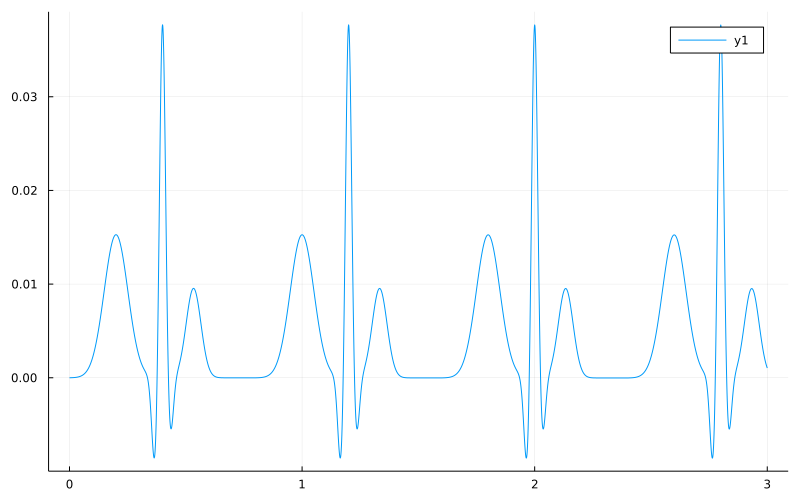

In [4]:
plot(t, x[:, 3], size=(800, 500))

┌ Info: Saved animation to 
│   fn = /home/mrr00b00t/Documentos/projects/MSCH/tum-tum.gif
└ @ Plots /home/mrr00b00t/.julia/packages/Plots/LI4FE/src/animation.jl:114


Plots.AnimatedGif("/home/mrr00b00t/Documentos/projects/MSCH/tum-tum.gif")
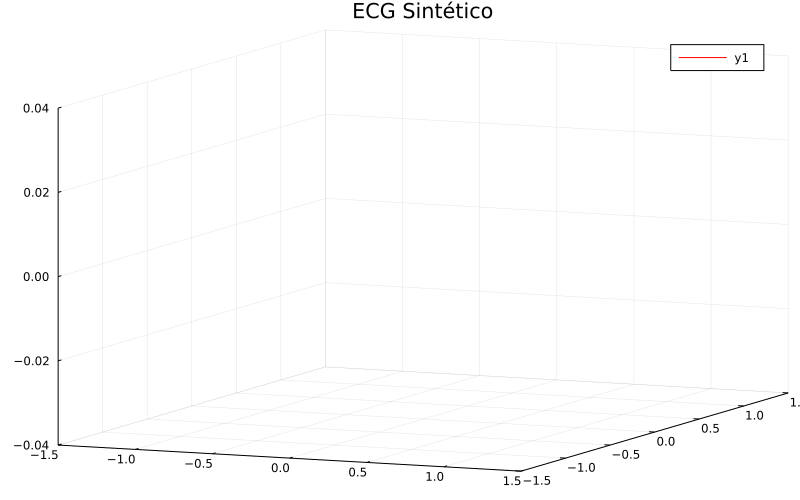

In [5]:
# initialize a 3D plot with 1 empty series
plt = plot3d(
    1,
    xlim  = (-1.5, 1.5),
    ylim  = (-1.5, 1.5),
    zlim  = (-0.04, 0.04),
    title = "ECG Sintético",
    lc    = :red,
    lw    = 3,
    size  = (800, 500)
)

# build an animated gif by pushing new points to the plot, saving every 10th frame
anim = @animate for i=1:length(t)
    push!(plt, x[i, 1], x[i, 2], x[i, 3])
end every 15

gif(anim, "tum-tum.gif", fps = 15)

In [6]:
Eₘₐₓ = 2.0
Eₘᵢₙ = 0.06
Tₘₐₓ = 0.2 + 0.15tc
T = 1.0

function Eₙ(tₙ)
    tₙ = 2tₙ
    n₁ = (tₙ / 0.7) ^ 1.9
    n₂ = (tₙ / 1.17) ^ 21.9
    return 1.55 * (n₁ / (1 + n₁)) * (1 / (1 + n₂))
end;

function E(t) 
    return (Eₘₐₓ - Eₘᵢₙ) * Eₙ(t/Tₘₐₓ) + Eₘᵢₙ
end;

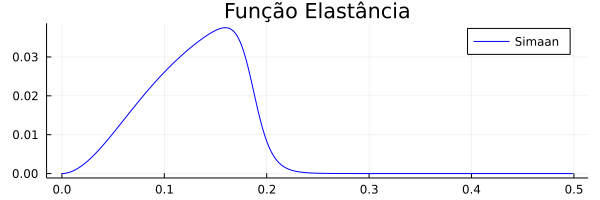

In [7]:
tₑ = (t[1:(length(t)÷6)])
simaan = map(Eₙ, tₑ .% T ./ Tₘₐₓ)
plot(tₑ, simaan ./ (1/maximum(x[:, 3])), label="Simaan", size = (600, 200), color="blue", title="Função Elastância")

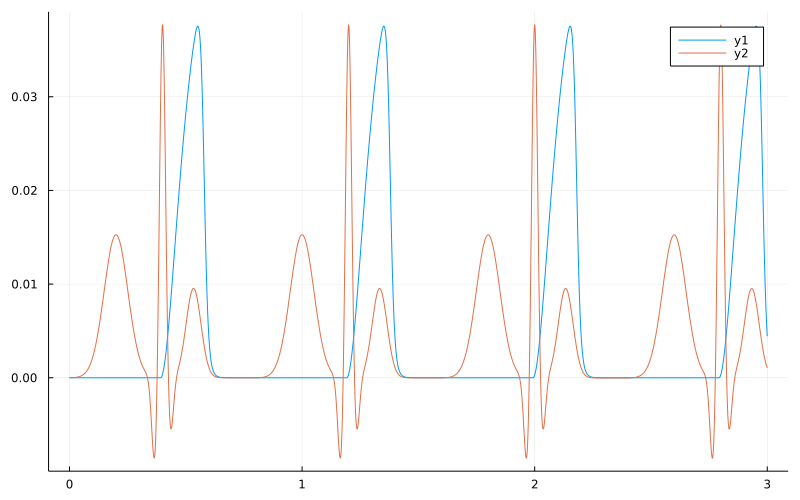

In [8]:
xᵣ = map(x[:, 3]) do xᵢ
    xᵢ >= 0.03 ? 1.0 : 0.0
end

for i ∈ 1:length(xᵣ)
    if xᵣ[i] == 1.0
        for j ∈ 1:length(simaan)
            #println(i," ",j)
            if i+j-1 <= length(xᵣ)
                xᵣ[i+j-1] = simaan[j]
            end
        end
        
        i += length(simaan)
    end
end

plot(t, xᵣ ./ (1/maximum(x[:, 3])), size=(800, 500))
plot!(t, x[:, 3])